                                                               Mini-Project-2

Workflow

The computation entails the following steps.

Select the dimensions of study (L in m; t in Days); Q will be m^3/d
 and BU = Ti = m^2/d
Select projection to use. Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
Select the Well Location (get lat-lon coordinates) convert to AEA projection
Extract Transmissivity values at the well (from interpolated T gpkg file)
Obtain the mean water levels (computed earlier) for wells in a gpkg fle
Convert the meam water levels file to AEA projection and compute X and Y coordinates
Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y
Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient
Compute the capture zone polygon in model coordinates (well is at 0,0)
Convert the capture zone polygon to AEA projection coordinates use suitable transformation
Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction
Create a shapely polygon (object) of the capture zone. Export to a gpkg file
Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.

Import Libraries

In [177]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu
from matplotlib_scalebar.scalebar import ScaleBar

Set Working Directory

In [180]:
path = "D:\\Mini-project-2"
os.chdir(path)

In [182]:
import pandas as pd


In [188]:
# Load CSV data (ensure correct paths)
gcmeanwell_df = pd.read_csv('gcmeanwell.csv')
pumpwell_df = pd.read_csv('pumpwell_jef.csv')
tvalues_df = pd.read_csv('Tvalues.csv')


In [190]:

fname = 'PWells_GAM.gpkg'
Tval = gpd.read_file(fname)


# Step 1: Define the study parameters (L, t, Q, BU)

In [193]:
# Step 1: Define the study parameters (L, t, Q, BU)
L = 1000  # Length in meters
t = 365  # Time in days (e.g., one year)
Q = 500  # Discharge in m^3/d
BU = 1.5  # Transmissivity in m^2/d

# Step 2: Select the projection to use

In [196]:
import geopandas as gpd
# Define the projection
projection = "EPSG:6350"

# Load your GeoDataFrame
data = gpd.read_file('PWells_GAM.gpkg')

# Reproject the GeoDataFrame to Albers Equal Area Conic for CONUS
data_aea = data.to_crs(projection)

# Print or inspect the reprojected data
print(data_aea.head())


                                            geometry
0  POLYGON ((10410634.935 3400991.93, 10410358.37...


# Step 3: Read well locations and convert to AEA projection

In [199]:
# Step 3: Read well locations and convert to AEA projection
well_gdf = gpd.read_file('JeffersonWGS84.gpkg')  

# Assuming the well locations are in WGS84 (EPSG:4326)
well_gdf = well_gdf.to_crs(epsg=6350)

# Inspect the new coordinates
print(well_gdf.head())

   CMPTRL_CNT  DPS_CNTY_N FIPS_ST_CN  TXDOT_CNTY  TXDOT_DIST    CNTY_NM  GID  \
0         123         123      48245         124          20  Jefferson   59   

                                            geometry  
0  MULTIPOLYGON (((174150.879 791463.906, 174162....  


C:\Nahida\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'JeffersonWGS84.gpkg': 'Jefferson' (default), 'JeffersonWGS84'. Specify layer parameter to avoid this warning.
  result = read_func(


# Step 4: Extract transmissivity values

In [202]:
import geopandas as gpd
from shapely.geometry import Point

# Load the interpolated transmissivity data
T_data = gpd.read_file('PWells_GAM.gpkg')  # Replace with your file name

# Set the projection to Albers Equal Area if not already in this projection
projection = "EPSG:6350"
T_data = T_data.to_crs(projection)

# Define the well's location (in latitude and longitude) and convert to the same projection
well_lat = 30.130555  
well_lon = -94.213889 

# Create a GeoDataFrame for the well location in WGS84, then reproject to match transmissivity data
well_location = gpd.GeoDataFrame(
    {'well_id': [1]},  # Well identifier
    geometry=[Point(well_lon, well_lat)],
    crs="EPSG:4326"  # Initial projection in WGS84 (lat-lon)
).to_crs(projection)




5.Obtain the mean water levels (computed earlier) for wells in a csv file

In [205]:
import pandas as pd

# Load the water levels data from a CSV file
water_levels = pd.read_csv('gcmeanwell.csv')  # Replace with your actual file name

# Check the data to identify the column for water levels
print(water_levels.head())  # Look for the column with water level values

# Remove any trailing spaces in column names
water_levels.columns = water_levels.columns.str.strip()

# Calculate the mean water level across all records
mean_water_level = water_levels['WaterElevation'].mean()  # Use the correct column name (no extra space)

# Print the overall mean water level
print("Mean WaterElevation:", mean_water_level)


   Unnamed: 0  StateWellNumber     County  LongitudeDD  LatitudeDD  \
0           0          6154901  Jefferson   -94.266112   30.134722   
1           1          6154902  Jefferson   -94.271111   30.159167   
2           2          6154904  Jefferson   -94.270278   30.161667   
3           3          6154905  Jefferson   -94.271389   30.159167   
4           7          6155701  Jefferson   -94.213889   30.130555   

     LandSurfaceElevationMethod  WellDepth  WaterElevation  DepthFromLSD  
0    Interpolated From Topo Map       21.0       23.100000      6.900000  
1  Digital Elevation Model -DEM      450.0      -17.178889     45.178889  
2  Digital Elevation Model -DEM      530.0      -17.287143     44.287143  
3    Interpolated From Topo Map      572.0      -25.338571     51.338571  
4    Interpolated From Topo Map       68.0       27.000000      9.000000  
Mean WaterElevation: 6.466726928029188


6.Convert the meam water levels file to AEA projection and compute X and Y coordinates

In [208]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load your CSV file containing the water levels data
# Assuming 'latitude' and 'longitude' columns in the CSV
df = pd.read_csv('gcmeanwell.csv')

# Create a GeoDataFrame from the CSV
# Assuming the CSV contains 'latitude' and 'longitude' columns
gdf = gpd.GeoDataFrame(df, 
                       geometry=[Point(lon, lat) for lon, lat in zip(df['LongitudeDD'], df['LatitudeDD'])],
                       crs="EPSG:4326")  # Assuming the input CRS is WGS84 (EPSG:4326)

#  Reproject the data to EPSG:5070 (Albers Equal Area)
gdf = gdf.to_crs(epsg=5070)

# Step 4: Extract X and Y coordinates from the geometry
gdf['X'] = gdf.geometry.x
gdf['Y'] = gdf.geometry.y

#  Save the updated data with new coordinates to a new CSV (optional)
gdf.to_csv('gcmeanwell.csv', index=False)

# Show the updated DataFrame with new X, Y coordinates (optional)
print(gdf[['LatitudeDD', 'LongitudeDD', 'X', 'Y']].head())


   LatitudeDD  LongitudeDD              X              Y
0   30.134722   -94.266112  166834.846987  785849.276114
1   30.159167   -94.271111  166304.522818  788553.615566
2   30.161667   -94.270278  166379.619326  788832.555902
3   30.159167   -94.271389  166277.793526  788553.162588
4   30.130555   -94.213889  171867.858370  785479.863195


7.Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y

     LandSurfaceElevationMethod  WellDepth  WaterElevation  DepthFromLSD  \
0    Interpolated From Topo Map       21.0       23.100000      6.900000   
1  Digital Elevation Model -DEM      450.0      -17.178889     45.178889   
2  Digital Elevation Model -DEM      530.0      -17.287143     44.287143   
3    Interpolated From Topo Map      572.0      -25.338571     51.338571   
4    Interpolated From Topo Map       68.0       27.000000      9.000000   

   Hydraulic_Head  
0       16.200000  
1      -62.357778  
2      -61.574286  
3      -76.677143  
4       18.000000  
Slope in X direction (head change per unit X): -0.0005254927179519342
Slope in Y direction (head change per unit Y): -3.1191532481296625e-05
Intercept (Hydraulic Head at origin): 107.95639709282679


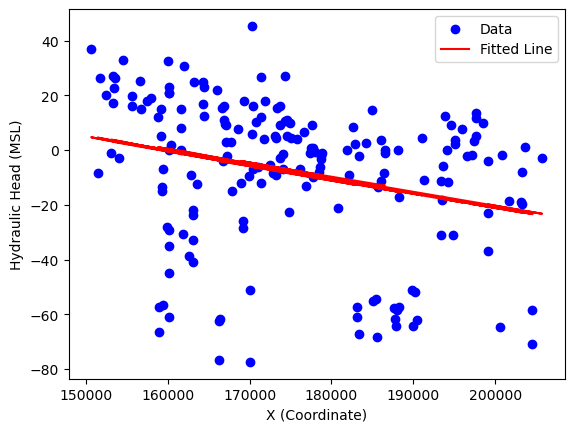

Groundwater flow direction (slope in X, Y): (-0.0005254927179519342, -3.1191532481296625e-05)
Gradient magnitude (steepness of flow): 0.0005264176177893773


In [211]:
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#  Load your data (assuming you already have the CSV or GeoDataFrame with X, Y, and Hydraulic Head)
df = pd.read_csv('gcmeanwell.csv')

#  Strip any leading or trailing spaces from the column names
df.columns = df.columns.str.strip()

#  Compute Hydraulic Head (using DepthFromLSD for the calculation)
df['Hydraulic_Head'] = df['WaterElevation'] - df['DepthFromLSD']

# Show the updated DataFrame with Hydraulic Head
print(df[['LandSurfaceElevationMethod', 'WellDepth', 'WaterElevation', 'DepthFromLSD', 'Hydraulic_Head']].head())

#  Extract X, Y coordinates and Hydraulic Head
X = df[['X', 'Y']]  # X and Y columns
y = df['Hydraulic_Head']  # Corrected column name

#  Initialize the Linear Regression model
model = LinearRegression()

#  Fit the model (perform the regression)
model.fit(X, y)

#  Get the regression coefficients (slopes)
slope_x, slope_y = model.coef_

#  Get the intercept (this is the hydraulic head at the origin)
intercept = model.intercept_

#  Print out the results
print(f"Slope in X direction (head change per unit X): {slope_x}")
print(f"Slope in Y direction (head change per unit Y): {slope_y}")
print(f"Intercept (Hydraulic Head at origin): {intercept}")

#  Plot the fitted model vs. actual data
plt.scatter(df['X'], df['Hydraulic_Head'], label='Data', color='blue')
plt.plot(df['X'], model.predict(X), label='Fitted Line', color='red')
plt.xlabel('X (Coordinate)')
plt.ylabel('Hydraulic Head (MSL)')
plt.legend()
plt.show()

# Calculate the groundwater flow direction and gradient
# The gradient gives you the approximate regional groundwater flow direction
flow_direction = (slope_x, slope_y)
gradient_magnitude = (slope_x**2 + slope_y**2)**0.5

print(f"Groundwater flow direction (slope in X, Y): {flow_direction}")
print(f"Gradient magnitude (steepness of flow): {gradient_magnitude}")


8.Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient

Step 8 and 9.Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradientcompute the capture zone polygon in model coordinates (well is at 0,0)

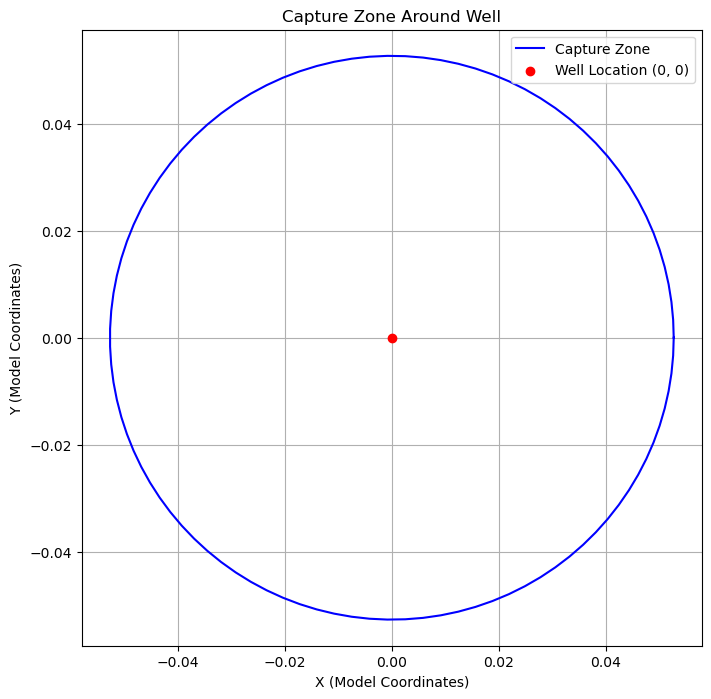

Capture Zone Polygon saved as 'JeffersonWGS84.gpkg'.


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Load your data (assuming you already have the CSV or GeoDataFrame with X, Y, and Hydraulic Head)
df = pd.read_csv('gcmeanwell.csv')

#  Strip any leading or trailing spaces from the column names
df.columns = df.columns.str.strip()

#  Compute Hydraulic Head (using DepthFromLSD for the calculation)
df['Hydraulic_Head'] = df['WaterElevation'] - df['DepthFromLSD']

#  Extract X, Y coordinates and Hydraulic Head
X = df[['X', 'Y']]  # X and Y columns
y = df['Hydraulic_Head']  # Corrected column name

#  Initialize the Linear Regression model
model = LinearRegression()

# Fit the model (perform the regression)
model.fit(X, y)

#  Get the regression coefficients (slopes)
slope_x, slope_y = model.coef_

#  Compute the gradient magnitude (resultant gradient)
resultant_gradient = np.sqrt(slope_x**2 + slope_y**2)

#  Define the capture zone radius based on the gradient magnitude
# Here we define the radius as a multiple of the gradient magnitude, e.g., 100 times the gradient
capture_zone_radius = resultant_gradient * 100  # You can adjust this factor

#  Create a circular capture zone polygon (simplified approach)
# We'll create a circle around (0, 0) (the well location) with the calculated radius
angles = np.linspace(0, 2 * np.pi, 100)
x_circle = capture_zone_radius * np.cos(angles)
y_circle = capture_zone_radius * np.sin(angles)

#  Create a polygon representing the capture zone
capture_zone_polygon = Polygon(zip(x_circle, y_circle))

#  Create a GeoDataFrame with the capture zone polygon
gdf = gpd.GeoDataFrame({'geometry': [capture_zone_polygon]}, crs="EPSG:4326")  # Assuming WGS84 (EPSG:4326)

#  Save the GeoDataFrame as a GeoPackage (GPKG)
gdf.to_file('JeffersonWGS84.gpkg', driver="GPKG")

#  Visualize the well and capture zone
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label='Capture Zone', color='blue')
plt.scatter(0, 0, color='red', label='Well Location (0, 0)', zorder=5)
plt.xlabel('X (Model Coordinates)')
plt.ylabel('Y (Model Coordinates)')
plt.title('Capture Zone Around Well')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

#  Check the saved file and print the details
print("Capture Zone Polygon saved as 'JeffersonWGS84.gpkg'.")


#Convert the capture zone polygon to AEA projection coordinates use suitable transformation

In [216]:
import geopandas as gpd

# Load existing data, e.g., from a GeoPackage
input_gpkg_path = "JeffersonWGS84.gpkg"  # Replace with actual path
gdf = gpd.read_file(input_gpkg_path)

# Optionally transform to a different CRS, e.g., Albers Equal Area
gdf = gdf.to_crs("EPSG:5070")  # Change CRS to AEA (EPSG:5070) if needed

# Save as a shapefile
output_shapefile_path = "capture_zone_AEA.shp"  # Replace with desired output path
gdf.to_file(output_shapefile_path)

print(f"Shapefile saved: {output_shapefile_path}")


C:\Nahida\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'JeffersonWGS84.gpkg': 'Jefferson' (default), 'JeffersonWGS84'. Specify layer parameter to avoid this warning.
  result = read_func(


Shapefile saved: capture_zone_AEA.shp


In [217]:
import geopandas as gpd

# Replace these with your actual file paths
input_shapefile_path = "capture_zone_AEA.shp"  # Input shapefile path
output_csv_path = "pumpwell_jef.csv"  # Output CSV path
output_gpkg_path = "JeffersonWGS84.gpkg"  # Output GeoPackage path

# Load the capture zone polygon shapefile
capture_zone = gpd.read_file(input_shapefile_path)

# Set the current coordinate system if it's not already defined
# Assuming WGS84 (EPSG:4326) as the original CRS for lat/lon data
capture_zone = capture_zone.set_crs("EPSG:4326", allow_override=True)

# Transform the polygon to Albers Equal Area (EPSG:5070) for the contiguous U.S.
capture_zone_aea = capture_zone.to_crs("EPSG:5070")

# Save the transformed data as a CSV file (without geometry column)
capture_zone_aea.drop(columns="geometry").to_csv(output_csv_path, index=False)

# Save the transformed data as a GeoPackage (GPKG) file (with geometry)
capture_zone_aea.to_file(output_gpkg_path, driver="GPKG")

print(f"Data saved as CSV: {output_csv_path}")
print(f"Data saved as GeoPackage: {output_gpkg_path}")


Data saved as CSV: pumpwell_jef.csv
Data saved as GeoPackage: JeffersonWGS84.gpkg


#Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction

In [219]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

 # Replace with your actual flow direction
flow_direction_deg = 45  

# Convert the angle to radians
flow_direction_rad = np.radians(flow_direction_deg)

# Function to apply rotation to each point
def rotate_coordinates(x, y, angle_rad):
    # Apply rotation matrix
    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    return x_new, y_new

# Load your data (example with points)
data = {
    "id": [1, 2, 3],
    "name": ["Point1", "Point2", "Point3"],
    "geometry": [Point(-94.2, 30.1), Point(-94.3, 30.2), Point(-94.4, 30.3)]
}

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")  # WGS84 for lat/lon

# Extract X and Y coordinates from the geometry
gdf['X'] = gdf.geometry.x
gdf['Y'] = gdf.geometry.y

# Apply rotation to the coordinates
gdf['X_rot'], gdf['Y_rot'] = zip(*gdf.apply(lambda row: rotate_coordinates(row['X'], row['Y'], flow_direction_rad), axis=1))

# Create new Point geometries with the rotated coordinates
gdf['geometry_rot'] = gdf.apply(lambda row: Point(row['X_rot'], row['Y_rot']), axis=1)

# Drop the original geometry column if you want to avoid confusion
gdf = gdf.drop(columns="geometry")

# Set the new rotated geometry as the active geometry
gdf = gdf.set_geometry('geometry_rot')

# Save the transformed data as a new shapefile
output_shapefile_path = "capture_zone_transformed.shp"
gdf.to_file(output_shapefile_path)

# Optionally save as CSV (without geometry column)
output_csv_path = "pumpwell_jef.csv"
gdf.drop(columns="geometry_rot").to_csv(output_csv_path, index=False)

print(f"Transformed shapefile saved: {output_shapefile_path}")
print(f"Transformed CSV saved: {output_csv_path}")


Transformed shapefile saved: capture_zone_transformed.shp
Transformed CSV saved: pumpwell_jef.csv


C:\Users\nahid\AppData\Local\Temp\ipykernel_12008\2033345069.py:47: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_path)
C:\Nahida\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


#Create a shapely polygon (object) of the capture zone. Export to a gpkg file

In [221]:
import geopandas as gpd
from shapely.geometry import Polygon

#  Create a Shapely Polygon (replace with actual coordinates of your capture zone)
polygon_coords = [(-94.2, 30.1), (-94.3, 30.2), (-94.4, 30.3), (-94.2, 30.4), (-94.2, 30.1)]

# Create the Shapely Polygon object
capture_zone_polygon = Polygon(polygon_coords)

#  Create a GeoDataFrame containing the Polygon
data = {
    "id": [1],
    "zone_name": ["Capture Zone"],
    "geometry": [capture_zone_polygon]
}

gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")  # WGS84 for lat/lon (change if necessary)

#  Export to GeoPackage (GPKG)
output_gpkg_path = "capture_zone.gpkg"  
gdf.to_file(output_gpkg_path, driver="GPKG")

print(f"GeoPackage saved: {output_gpkg_path}")


GeoPackage saved: capture_zone.gpkg


#Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.

C:\Nahida\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'JeffersonWGS84.gpkg': 'Jefferson' (default), 'JeffersonWGS84'. Specify layer parameter to avoid this warning.
  result = read_func(


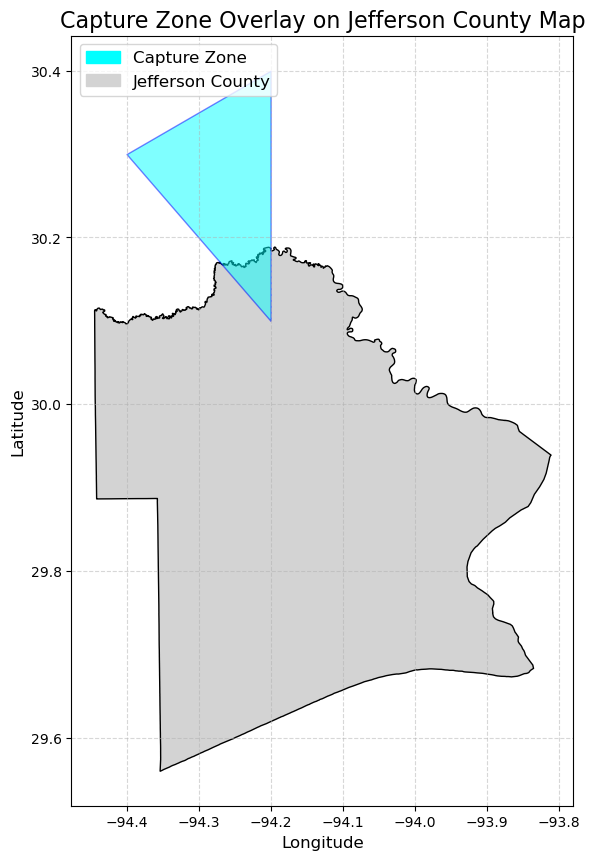

In [223]:
import geopandas as gpd
import matplotlib.pyplot as plt

#  Load the Jefferson County map
# Replace with the path to your Jefferson County shapefile or GeoPackage
jefferson_path = "JeffersonWGS84.gpkg"  # Path to Jefferson County map shapefile
jefferson_gdf = gpd.read_file(jefferson_path)

#  Load the capture zone polygon
capture_zone_path = "capture_zone.gpkg"  # Path to the GeoPackage with capture zone
capture_zone_gdf = gpd.read_file(capture_zone_path)

#  Plot the map
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Jefferson County map (base layer)
jefferson_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the capture zone polygon on top (overlay)
capture_zone_gdf.plot(ax=ax, color='cyan', alpha=0.5, edgecolor='blue')

#  Add embellishments
# Add a title and labels
ax.set_title("Capture Zone Overlay on Jefferson County Map", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add a grid for better readability
ax.grid(True, linestyle="--", alpha=0.5)

# Optionally, add a legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='cyan', label='Capture Zone'),
    mpatches.Patch(color='lightgrey', label='Jefferson County')
]
ax.legend(handles=legend_handles, loc="upper left", fontsize=12)

#  Set axis limits (adjust as per the extent of your data)
# ax.set_xlim([-94.5, -93.5])
# ax.set_ylim([29.5, 30.5])

#  Show the plot
plt.show()
